## NOW WITH GPU PROFILING!

## HDNN Demo

In [1]:
# package for gpu profiling
import ipyexperiments

In [2]:
import gc

In [3]:
import numpy as np
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
from torchdiffeq import odeint, odeint_adjoint

# nome che fa figo
from torchcontrol.arch_cpu_odeint import HDNN
from torchcontrol.predictors import MLP, CNN
from torchcontrol.utils import genpoints, dump_tensors

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except: pass

In [6]:
dump_tensors()

Total size: 0


### Data generation

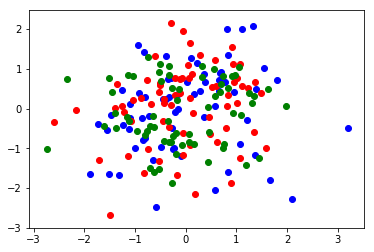

In [7]:
X, yn = datasets.make_classification(n_samples=200,n_informative=4,n_clusters_per_class=3,n_classes=3)
plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
plt.scatter(X[yn==2,0],X[yn==2,1],color='green')

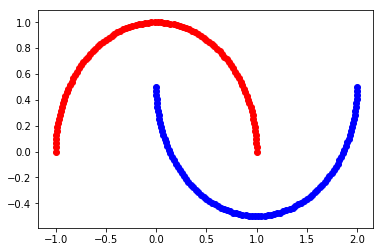

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.196
･ CPU:         0       0     1442 MB |
･ GPU:        41       0      751 MB |


In [46]:
X, yn = datasets.make_moons(n_samples=200)
plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
plt.scatter(X[yn==0,0],X[yn==0,1],color='red')

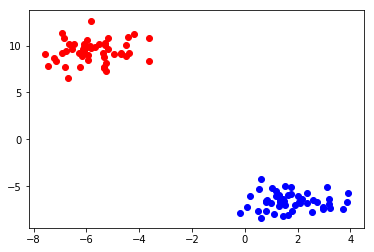

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.236
･ CPU:         0       0     2038 MB |
･ GPU:        -1       0     1623 MB |


In [83]:
X,yn = datasets.make_blobs(n_samples=100, centers = 2,n_features=2)
plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
plt.scatter(X[yn==0,0],X[yn==0,1],color='red')

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, yn, test_size=0.1, random_state=42)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.002
･ CPU:         0       0     2038 MB |
･ GPU:       -10       0     1613 MB |


In [85]:
# choose batch size here
bs = 90

X_train = torch.Tensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

train = data_utils.TensorDataset(X_train,y_train)
trainloader = data_utils.DataLoader(train, batch_size=bs, shuffle=True)

test = data_utils.TensorDataset(X_test,y_test)
testloader = data_utils.DataLoader(test, batch_size=bs, shuffle=True)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.032
･ CPU:         0       0     2038 MB |
･ GPU:         8       0     1621 MB |


## Learning a boundary in R2

-  HDNN wrapper is initialized with a predictor (also nn.Module) as input that is used during inference and the parameters of which are updated according to hamiltonian dynamics. The default fully connected network class is given as a baseline. 
-  NOTE: Bigger nets might require high amounts of CUDA memory and might thus crash. Further optimization is required

In [86]:
exp1 = ipyexperiments.IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1060 3GB (3072 RAM)


*** Current state:
RAM:  Used  Free  Total      Util
CPU:  2038  2836   8143 MB  25.03% 
GPU:  1619  1452   3072 MB  52.71% 


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.204
･ CPU:         0       0     2038 MB |
･ GPU:        -2       0     1619 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:01:57 (elapsed wallclock time)

*** Experiment memory:
RAM:  Consumed     Reclaimed
CPU:     595       0 MB (  0.00%)
GPU:     887       0 MB (  0.00%)

*** Current state:
RAM:  Used  Free  Total      Util
CPU:  2038  2837   8143 MB  25.03% 
GPU:  1629  1442   3072 MB  53.04% 


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.216
･ CPU:         0       0     2038 MB |
･ GPU:        10       0     1629 MB |


In [87]:
# example: [2,12,2] are the dense layers of the MLP predictor used, \
# whereas [1,2,0] are the a,b,c of the loss function. 2 is beta 
m = HDNN([2,10000,2],'MLP',[1,2,0.1],1).cuda()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.264
･ CPU:         7       0     2026 MB |
･ GPU:        -2       2     1627 MB |


In [55]:
# alternatively, using a CNN is also a possiblity
m = HDNN([1,12,12],'CNN',[1,2,0.2],1,[192,3]).cuda()

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.011
･ CPU:         0       0     1367 MB |
･ GPU:       -31       0      730 MB |


In [88]:
print('Initial accuracy on training dataset: {} %'.format(m.pred_accuracy(trainloader)))

Initial accuracy on training dataset: 0.0 %
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.017
･ CPU:         0       0     2026 MB |
･ GPU:       -11       2     1615 MB |


In [89]:
m.fit(trainloader,1,time_delta=500,method='odeint',iter_accuracy=10,ode_t=2,ode_step=300)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 14
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.00299207, 0.00668896])
 t_events: None
        y: array([[ 0.10915041,  0.11412241,  0.12018293],
       [-0.6489538 , -0.64013607, -0.62938724],
       [ 0.31155819,  0.31693392,  0.3234868 ],
       ...,
       [ 0.1271711 ,  0.12510048,  0.12284286],
       [ 0.78718299,  0.77807394,  0.76648751],
       [ 0.70047706,  0.69239516,  0.68302107]])
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:09.556
･ CPU:        17      12     2042 MB |
･ GPU:        -6      39     1609 MB |


In [90]:
print('Post-training accuracy on test dataset: {} '.format(m.pred_accuracy(testloader)))

Post-training accuracy on test dataset: 1.0 
･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.004
･ CPU:         0       0     2042 MB |
･ GPU:         1       2     1611 MB |


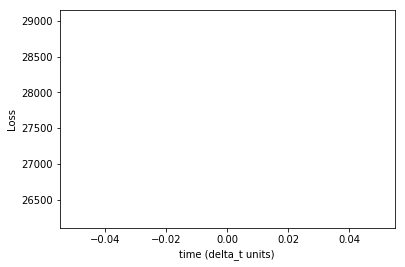

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.200
･ CPU:         0       0     2004 MB |
･ GPU:         5       0      870 MB |


In [62]:
m.plotLoss()

In [ ]:
m.plotParameters()

In [ ]:
m.plotVelocities()

## Create boundary plot

In [94]:
mp = genpoints(-15,15,-15,15,100)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.088
･ CPU:         0       2     2043 MB |
･ GPU:       -22       0     1608 MB |


In [95]:
y,idx = torch.max(torch.exp(m.predictor.forward(mp)),1)

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.038
･ CPU:         0       0     2043 MB |
･ GPU:        14     763     1623 MB |


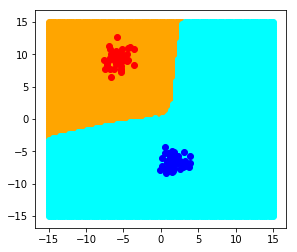

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.391
･ CPU:         0       0     2044 MB |
･ GPU:        10       4     1634 MB |


In [96]:
mp_r = mp[idx==0]
mp_b = mp[idx==1]
plt.figure(figsize=(4.5,4))
plt.scatter(mp_r[:,0].cpu(),mp_r[:,1].cpu(),color='orange')
plt.scatter(mp_b[:,0].cpu(),mp_b[:,1].cpu(),color='cyan')
plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
plt.scatter(X[yn==0,0],X[yn==0,1],color='red')

In [32]:
del exp1

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     1246 MB |
･ GPU:         1       0     1015 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:10:00 (elapsed wallclock time)

*** Newly defined local variables:
Deleted: idx, m, mp, mp_b, mp_r, y

*** Circular ref objects gc collected during the experiment:
cleared 7 objects (only temporary leakage)

*** Experiment memory:
RAM:  Consumed     Reclaimed
CPU:      70     998 MB (1408.09%)
GPU:     155      99 MB ( 63.88%)

*** Current state:
RAM:  Used  Free  Total      Util
CPU:   248  3535   8143 MB   3.05% 
GPU:   916  2155   3072 MB  29.83% 




## Experimental and useless stuff

In [99]:
theta_dot = torch.autograd.Variable()
theta_ddot = torch.autograd.Variable()
m = DumbNet(2,12,3)
d = iter(m.parameters())
for i in range(3):
    layer_shape = (next(d).shape)
    torch.cat((theta_dot,torch.autograd.Variable(torch.Tensor(torch.zeros(layer_shape)))))
    torch.cat((theta_ddot,torch.autograd.Variable(torch.Tensor(torch.zeros(layer_shape)))))

In [114]:
theta_dot = torch.autograd.Variable(torch.Tensor())
theta_ddot = torch.autograd.Variable(torch.Tensor())

In [ ]:
class HCycle(torch.autograd.Function):
    @staticmethod
    def forward(ctx,model,x,parameters):
        x = model.layer1(x)
        x = F.relu(x)
        x = model.layer2(x)
        return F.log_softmax(x)
    @staticmethod
    def backward(ctx,loss,model,parameters):
        
        weights_state = torch.matmul(A,grad_H)
        parameters = torchdiffeq.odeint(weights_state)

In [ ]:
class Update(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg()

def grad_reverse(x):
    return GradReverse.apply(x)

In [107]:
torchdiffeq.odeint()

AttributeError: module 'torchdiffeq' has no attribute 'odeint'

## Utils

In [75]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [140]:
def genpoints(xmin,xmax,ymin,ymax,Np):
    xx = np.linspace(xmin,xmax,Np)
    yy = np.linspace(ymin,ymax,Np)
    c = 1
    P = []
    for i in range(Np):
        for j in range(Np):
            P.append([xx[i],yy[j]])
    return np.array(P)

In [ ]:
def babba(m):
    d = iter(m.parameters())
    for layer in range(m.returnLength(i))

In [42]:
   import torch
import torch.nn as nn
from torchdiffeq import odeint
import torch.nn.functional as F
from operator import add
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# main class for all the ugly shit
class HDNN(nn.Module):
    def __init__(self, dense_layers, hparams, beta):
        '''
        High level wrapper of a Hamiltonian Differential Neural Network
        
        :dense_layer: list of dimensions of linear layers of the chosen HDNN predictor \
        (e.g [12,24,2] for 12-dimensional inputs and output size 2)
        :hparams: list [a,b,c] of loss function hyperparameters
        :beta: beta of F function of the weight dynamics
        
        NOTE: c term of the loss NOT implemented yet (no regularization). CUDA memory requirement for big 
        nets is rather big (not optimized)
        '''
        # initialize superclass method
        super().__init__()
        
        # create an attribute for HDNN for its predictor
        self.dense_layers = dense_layers
        self.predictor = MLP(self.dense_layers).to(device)
        
        # attribute self.len: each hidden layer has its own weight and bias tensors in self.predictor.state_dict() \
        # thus 2*(number of layers - 1)
        self.len = 2*(len(dense_layers)-1)
        
        # faster way to call predictor.parameters()
        self.p = self.predictor.parameters()
        
        # atm useless routine to calculate shapes of predictor.parameters() tensors at different layers
        # UNUSED
        #shape = []
        #itr = iter(self.predictor.parameters())
        #for i in range(self.len):
        #    p = next(itr)
        #    shape.append(p.shape)
        #self.shape = shape
        
        # simple assignment routine
        self.hparams = hparams
        self.dJ,self.dJddw = [], []
        self.beta = beta
        
        # creating weights and weight velocity lists of tensors according to predictor.state_dict()
        self.w,self.wdot = self.createStateVector(True,True)
        
        # creating flattened versions of self.w and self.wdot for gradient and state computations
        self.flat_w = self.flattenParamVector(False) 
        self.flat_wdot = self.flattenParamVector(True)
        self.count = 0
        
        #time counter for loss and parameter plotting
        self.time = 0 
        self.pLoss = []
        self.pW = []
        self.pWdot = []
        self.initializeRecord()
        
    def createStateVector(self,velocity=True,first_instance=True):
        w = []
        wdot = []
        itr = iter(self.predictor.parameters())
        for i in range(self.getLength()):
            param = next(itr)
            w.append(param.to(device))
            if first_instance:
                wdot.append(torch.rand((param.shape)).to(device))
        if velocity == True: return w,wdot
        else: return w
    
    def flattenParamVector(self,velocity=True):
        itr = iter(self.predictor.parameters())         
        if not velocity:
            w = next(itr).view(-1).to(device)
            for i in range(1,self.getLength()):
                w = torch.cat((w,(next(itr).view(-1)).to(device)))
        else:
            w = self.wdot[0].view(-1).to(device)
            for i in range(1,self.getLength()):
                w = torch.cat((w,self.wdot[i].view(-1).to(device)))
        return w

    def makeFMatrix(self):
            n = len(self.flat_dJ)
            In = torch.eye(n).to(device)
            On = torch.zeros((n,n)).to(device)
            B = self.beta*In          
            F = torch.cat((torch.cat((On,In),1),torch.cat((-In,-B),1)),0)
            return F
        
    
    def Gradient(self):
        itr = iter(self.predictor.parameters())
        dJddw = 2.*self.hparams[1]*self.flat_wdot
        #for idx,params in enumerate(self.wdot):
        #dJddw.append(2.*self.hparams[1]*self.wdot[idx])
        dJ_reg = 2.*self.hparams[2]*self.flat_w
        dJ = list(map(add,[next(itr).grad for i in range(self.getLength())],dJ_reg))
        self.dJ,self.dJddw = dJ, dJddw 
        
    def additionalTermsLoss(self):
        return torch.add(self.hparams[1]*torch.dot(self.flat_wdot,self.flat_wdot),\
        self.hparams[2]*torch.dot(self.flat_w,self.flat_w))
    
    def assignNewState(self,xi):
        self.flat_w = xi[:len(self.flat_w)]
        self.flat_wdot = xi[len(self.flat_w):2*len(self.flat_w)] 
        k = 0
        for i in range(self.getLength()):
            self.w[i] = self.flat_w[k:k+torch.numel(self.w[i])].view(self.w[i].shape)
            self.wdot[i] = self.flat_wdot[k:k+torch.numel(self.wdot[i])].view(self.wdot[i].shape)
            k += torch.numel(self.w[i])
        
    def loadStateDict(self):    
        new_state_dict = self.makeStateDict()
        self.predictor = MLP(self.dense_layers).to(device)
        self.predictor.load_state_dict(new_state_dict)
        
    def makeStateDict(self):
        d = {}
        for i,key in enumerate(self.predictor.state_dict().keys()):
                d[key] = self.w[i]
        return d
    
    @staticmethod
    def makeGenerator(lt):
        for i,d in enumerate(lt):
            yield d
    
    def flattenGradient(self):
        dJ = self.dJ[0].view(-1)
        #dJddw = self.dJddw[0].view(-1)
        for i in range(1,self.getLength()):
            dJ = torch.cat((dJ,self.dJ[i].view(-1)))
            #dJddw = torch.cat((dJddw,self.dJddw[i].view(-1)))
        return dJ, self.dJddw
    
    def assignFlatGradient(self):
        self.flat_dJ,self.flat_dJddw = self.flattenGradient()
    
    def getConcatGradient(self):
        return torch.cat((self.flat_dJ,self.flat_dJddw))
    
    def fixInputOutput(self,x,y):
        self.x = x
        self.y = y
        
    def setXi(self):
        self.xi = torch.cat((self.flat_w,self.flat_wdot))

    def getLength(self):
        return self.len
    
    def getParamShape(self):
        return self.shape
    
    def pred_accuracy(self,testloader):
        tot = 0
        count = 0
        for i,d in enumerate(testloader):
            x,y = d
            x,y = x.to(0),y.to(0)
            _, idx = torch.max(torch.exp(self.predictor.forward(x)),1)  
            for i in range(len(idx)):
                if idx[i] == y[i]:
                    count += 1
                tot += 1
        return count/tot
    
    def initializeRecord(self):
        for i in range(len(self.flat_w)):
            self.pW.append([])
            self.pWdot.append([])
            
    def recordLoss(self,main_loss,additional_terms_loss,delta_t):
        if self.time % delta_t == 0:
            self.pLoss.append(main_loss+additional_terms_loss)
    
    def plotLoss(self):
        plt.plot(self.pLoss, color='red')
        plt.ylabel('Loss')
        plt.xlabel('time (delta_t units)')
        
    def recordParameters(self,pW,pWdot,delta_t):
        if self.time % delta_t == 0:
            for i in range(len(pW)):
                self.pW[i].append(pW[i].cpu().detach().numpy()) 
                self.pWdot[i].append(pWdot[i].cpu().detach().numpy()) 
        
    def plotParameters(self):
        for i in range(len(self.pW)):
            plt.plot(self.pW[i])
            
    def plotVelocities(self):
        for i in range(len(self.pW)):
            plt.plot(self.pWdot[i])
            
    def forward(self,t,xi):
        self.assignNewState(xi)
        self.loadStateDict()
        self.optimizer = torch.optim.Adam(self.predictor.parameters())
        self.optimizer.zero_grad()
        yhat = self.predictor.forward(self.x)
        loss = self.criterion(yhat,self.y)#self.additionalTermsLoss())
        loss.backward(retain_graph=True)
             
        #self.recordLoss(loss,self.additionalTermsLoss(),self.time_delta)
        #self.recordParameters(self.flat_w,self.flat_wdot,self.time_delta)
        
        self.Gradient()
        self.assignFlatGradient()
        F = self.makeFMatrix() 
        grad_flat = self.getConcatGradient()
        dxdt = torch.matmul(F,grad_flat)
        
        #timer for parent
        self.time += 1
        return dxdt 
    
    def fit(self, trainloader, epoch = 3, time_delta = 1, iter_accuracy = 10, t_odeint = 10):
        '''
        :trainloader: DataLoader with training data
        :epoch: number of training epochs
        :time_delta: time steps required for a single recording of loss and parameters. Higher is better for speed
        :iter_accuracy: iterations until test accuracy is displayed
        :t_odeint: number of odeint time steps (per batch)
        '''
        
        self.criterion = F.nll_loss    
        t = torch.linspace(.0, .25, t_odeint)
        self.setXi()
        self.time_delta = time_delta
        for e in range(epoch): 
            for i, data in enumerate(trainloader): 
                x,y= data
                x,y = x.to(device),y.to(device)             
                self.fixInputOutput(x,y)
                self.optimizer = torch.optim.Adam(self.predictor.parameters())
                self.optimizer.zero_grad()
                #dynamics = HDNN(self.getConcatGradient(),self.dJ,self.flat_dJ,self.beta)
                func = self
                xi = odeint(func, self.xi, t)                
                self.xi = xi[-1]
                self.assignNewState(xi[-1])
                self.loadStateDict()
                self.count += 1                
                if self.count % iter_accuracy == 0 and self.count != 0:
                    print('Number of odeint and parameters reassignment iterations: {}'.format(self.count))
                    print('In-training accuracy estimate: {}'.format(self.pred_accuracy(trainloader)))
  

                  
# class that handles the internal odeint loop
# CURRENTLY UNUSED
                    
class HamiltonianDynamics(nn.Module):
    def __init__(self, HDNN, criterion, optimizer, x, y, time_delta):
        super().__init__()
        self.parent = HDNN
        self.criterion = criterion
        self.optimizer = optimizer
        self.x = x
        self.y = y
        
        # time delta for recording purposes (loss and parameters)
        self.time_delta = time_delta
        
    def forward(self,t,xi):
        self.parent.assignNewState(xi)
        self.parent.loadStateDict()
        self.optimizer = torch.optim.Adam(self.parent.predictor.parameters())
        self.optimizer.zero_grad()
        yhat = self.parent.predictor.forward(self.x)
        loss = self.criterion(yhat,self.y)#self.additionalTermsLoss())
        loss.backward(retain_graph=True)
        
        self.parent.recordLoss(loss,self.parent.additionalTermsLoss(),self.time_delta)
        self.parent.recordParameters(self.parent.flat_w,self.parent.flat_wdot,self.time_delta)
        
        self.parent.Gradient()
        self.parent.assignFlatGradient()
        F = self.parent.makeFMatrix() 
        grad_flat = self.parent.getConcatGradient()
        dxdt = torch.matmul(F,grad_flat)
        
        #timer for parent
        self.parent.time += 1
        return dxdt   

# predictor class 
class MLP(nn.Module):
    def __init__(self, dense_layers):
        '''
        Simple dense MLP class used as predictor for HDNN
        
        :smax_l: leave True for softmax applied to ouput
        '''
        super().__init__()
        self.dense_layers = nn.ModuleList([nn.Linear(dense_layers[i], dense_layers[i + 1]) \
                                           for i in range(len(dense_layers) - 1)])
    def getLength(self):
        return len(self.dense_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.dense_layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x,dim=-1)

# USELESS for now
class HDNN_adjoint(nn.Module):
    def __init__(self, grad_flat, dJ, flat_dJ,beta):
        super().__init__()
        self.grad_flat = grad_flat
        self.dJ = dJ
        self.flat_dJ = flat_dJ
        self.beta = beta
            
    def HamiltonianModel(self,t):
        #for i,d in enumerate(self.dJ):
        n = len(self.flat_dJ)
        In = torch.eye(n).to(device)
        On = torch.zeros((n,n)).to(device)
        B = self.beta*In
        F = torch.cat((torch.cat((On,In),1),torch.cat((-In,-B),1)),0)
        print(F.shape,self.grad_flat.shape)
        dxdt = torch.matmul(F,self.grad_flat)
        return dxdt                    